In [2]:
!pip install orkg

In [3]:
from orkg import ORKG, Hosts

orkg = ORKG(host=Hosts.SANDBOX)


In [4]:
import requests
from json.decoder import JSONDecodeError
import json

**Get The Papers with the ContribuationsID**

In [5]:
import pandas as pd
import requests

papers_id = ['R345000', 'R346053', 'R346042', 'R346036', 'R346029', 'R345024', 'R346058', 'R345018', 'R344076', 'R345008']

papers = {}

response = requests.get(f'https://sandbox.orkg.org/api/statements/subject/R345024')
data = response.json()['content']
for paper_id in papers_id:
    response = requests.get(f'https://sandbox.orkg.org/api/statements/subject/{paper_id}', headers={'Accept': 'application/json'})

    if response.status_code == 200:
        data = response.json()['content']
        paper_title = None
        contribution_id = None
        dataset_name = None
        for statement in data:
            if 'Contribution 1' in statement['object']['label']:
                contribution_id = statement['object']['id']
            elif 'label' in statement['subject']:
                paper_title = statement['subject']['label']

        if paper_title and contribution_id:
            papers[paper_id] = {'paper_title': paper_title, 'contribution_id': contribution_id}
            print(f"Paper: {paper_title} (ID: {paper_id}), Contribution 1 ID: ({contribution_id})")
        else:
            print(f"No paper title or Contribution 1 ID found for Paper ID: {paper_id}")
    else:
        print(f"Error retrieving data for Paper ID {paper_id}: {response.status_code}")

Paper: GrAMME: Semi-Supervised Learning using Multi-layered Graph Attention Models (ID: R345000), Contribution 1 ID: (R345002)
Paper: Neural Architecture Search with Reinforcement Learning (ID: R346053), Contribution 1 ID: (R346055)
Paper: How good is your blind spot sampling policy? (ID: R346042), Contribution 1 ID: (R346045)
Paper: Feature selection with test cost constraint (ID: R346036), Contribution 1 ID: (R346038)
Paper: Setting decision thresholds when operating conditions are uncertain (ID: R346029), Contribution 1 ID: (R346032)
Paper: PermuteAttack: Counterfactual Explanation of Machine Learning Credit Scorecards (ID: R345024), Contribution 1 ID: (R345026)
Paper: Time-Series Representation Learning via Temporal and Contextual Contrasting (ID: R346058), Contribution 1 ID: (R346060)
Paper: FairNeuron: improving deep neural network fairness with adversary games on selective neurons (ID: R345018), Contribution 1 ID: (R345021)
Paper: Interpretable Counterfactual Explanations Guided

**Add the Dataset that used in the Contribution with the ContributionID**


In [6]:
import pandas as pd
import time
response = requests.get(f'https://sandbox.orkg.org/api/statements/predicate/P9001', headers={'Accept': 'application/json'})
data = response.json()
dataset_info = []
resource_ids = ['R345042', 'R343217', 'R345011',  'R345031', 'R346033', 'R346039','R346046', 'R346061', 'R347004', 'R345003']
resource_test_ids = ['R355385', 'R355390', 'R355408', 'R355430', 'R355992', 'R356002', 'R356061','R350002', 'R355385', 'R350040', 'R354165']
for item in data['content']:
    contribution = item['subject']['id']
    dataset = item['object']['id']
    if dataset in resource_ids:
        dataset_name = item['object']['label']
        dataset_info.append({'ContributionID': contribution, 'Dataset': dataset, 'Dataset_name': dataset_name})

df = pd.DataFrame(dataset_info)
df

,ContributionID,Dataset,Dataset_name
0,R344079,R345031,breast-w
1,R346060,R346061,har
2,R346045,R346046,pc1
3,R346055,R347004,CIFAR-10
4,R346038,R346039,Tic-tac-toe
5,R346032,R346033,Spambase
6,R345026,R343217,credit-g
7,R345021,R345042,mnist
8,R345010,R345011,ilpd
9,R345002,R345003,balance-scale




# **Merging the 2 Blocks**

In [9]:
import pandas as pd
import requests

response = requests.get(f'https://sandbox.orkg.org/api/statements/predicate/P9001', headers={'Accept': 'application/json'})
data = response.json()
dataset_info = []
resource_ids = ['R345042', 'R343217', 'R345011',  'R345031', 'R346033', 'R346039','R346046', 'R346061', 'R347004', 'R345003']
contribution_ids = {}
resource_test_ids = ['R355385', 'R355390',  'R355408', 'R355430', 'R355992', 'R356002', 'R356061', 'R356846','R350002', 'R354165']

for item in data['content']:
    contribution = item['subject']['id']
    dataset = item['object']['id']
    if dataset in resource_ids:
        dataset_name = item['object']['label']
        dataset_info.append({'ContributionID': contribution, 'Dataset': dataset, 'Dataset_name': dataset_name})
        contribution_ids[dataset_name] = contribution

df = pd.DataFrame(dataset_info)

all_dfs = []

for resource_id in resource_ids:
    response = requests.get(f'https://sandbox.orkg.org/api/statements/subject/{resource_id}', headers={'Accept': 'application/json'})

    if response.status_code == 200:
        data = response.json()
        statements = data['content']

        filtered_statements = [statement for statement in statements if statement['predicate']['label'] not in ['hasFeature', 'maxValue', 'mean', 'minValue', 'skewness', 'kurtosis']]

        df = pd.DataFrame({
            'resource_name': [statement['subject']['label'] for statement in filtered_statements],
            'predict_name': [statement['predicate']['label'] for statement in filtered_statements],
            'object_id': [statement['object']['id'] for statement in filtered_statements],
            'object_label': [statement['object']['label'] for statement in filtered_statements],
            'object_datatype': [statement['object'].get('datatype', None) for statement in filtered_statements]
        })

        all_dfs.append(df)
        all_dfs

    else:
        print(f'Failed to fetch data for resource ID {resource_id}:', response.status_code)

result_df = pd.concat(all_dfs, ignore_index=True)
result_df = result_df.pivot(index='resource_name', columns='predict_name', values='object_label')
result_df['ContributionID'] = result_df.index.map(lambda x: contribution_ids.get(x, None))
result_df


predict_name,Class Entropy,Normal Entropy,Number of classes,Number of instances,Standard Deviation Ratio,number of features,ContributionID
resource_name,,,,,,,
CIFAR-10,1.0,3.32,10,60000,0.52,3073,R346055
Spambase,0.97,0.97,2,4601,5.19,58,R346032
Tic-tac-toe,0.93,0.93,2,958,0,10,R346038
balance-scale,1.31,0.83,5,625,0.47,3,R345002
breast-w,0.93,0.93,2,699,0.90,10,R344079
credit-g,0.88,0.88,2,1000,0.46,21,R345026
har,2.58,0.99,6,10299,-0.21,562,R346060
ilpd,0.86,0.86,2,583,1.18,11,R345010
mnist,3.32,0.99,10,70000,28.30,785,R345021


In [10]:
matrix = result_df.values
print(matrix)

[['1.0' '3.32' '10' '60000' '0.52' '3073' 'R346055']
 ['0.97' '0.97' '2' '4601' '5.19' '58' 'R346032']
 ['0.93' '0.93' '2' '958' '0' '10' 'R346038']
 ['1.31' '0.83' '5' '625' '0.47' '3' 'R345002']
 ['0.93' '0.93' '2' '699' '0.90' '10' 'R344079']
 ['0.88' '0.88' '2' '1000' '0.46' '21' 'R345026']
 ['2.58' '0.99' '6' '10299' '-0.21' '562' 'R346060']
 ['0.86' '0.86' '2' '583' '1.18' '11' 'R345010']
 ['3.32' '0.99' '10' '70000' '28.30' '785' 'R345021']
 ['0.36' '0.36' '2' '1109' '2.11' '22' 'R346045']]


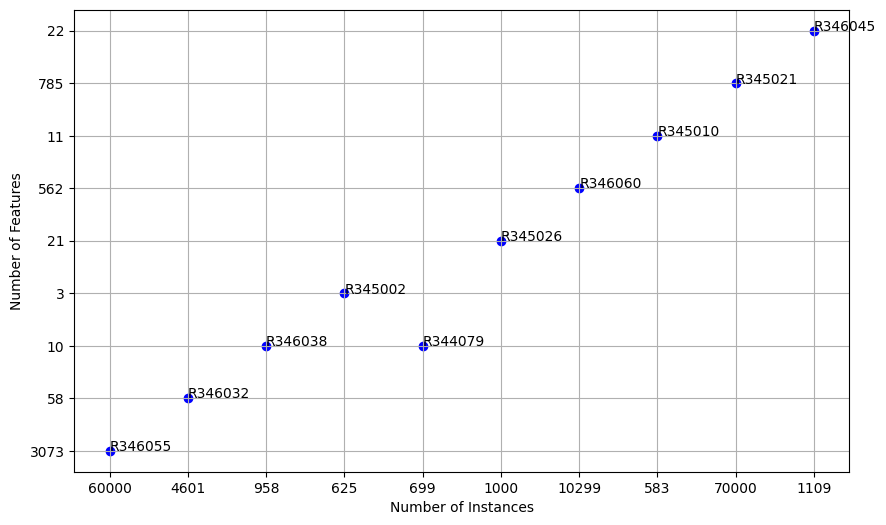

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Extracting columns from the matrix
instances = matrix[:, 3]  # Number of instances column
features = matrix[:, 5]  # Number of classes column
names = matrix[:, -1]  # ContributionID column

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(instances, features, color='blue')
plt.xlabel('Number of Instances')
plt.ylabel('Number of Features')

# Adding labels
for i, name in enumerate(names):
    plt.annotate(name, (instances[i], features[i]))

plt.grid(True)
plt.show()

In [12]:
from scipy.spatial.distance import cosine
from scipy.spatial import distance
import numpy as np

# Extract meta-features and ContribuationID
X_meta = matrix[:, :-1].astype(float)
contributions = matrix[:, -1]

# Compute cosine distance between meta-feature and ContribuationID
cosine_distances = [distance.cosine(meta_feature, [float(contribution[1:])]) for meta_feature, contribution in zip(X_meta, contributions)]

print("Cosine Distances:\n", cosine_distances)

Cosine Distances:
 [0.5713035248730401, 0.5858284695948504, 0.5858691738768866, 0.5848407492449554, 0.5831766295356493, 0.5815491508472641, 0.5697434270195186, 0.5806965321210915, 0.5869510002187512, 0.5819587011168263]


In [13]:
import pandas as pd
import requests

response = requests.get(f'https://sandbox.orkg.org/api/statements/predicate/P9001', headers={'Accept': 'application/json'})
data = response.json()
resource_ids = ['R345042', 'R343217', 'R345011',  'R345031', 'R346033', 'R346039','R346046', 'R346061', 'R347004', 'R345003'] #'R347004', resource_ids

dataset_info = []
resource_test_ids = ['R355390', 'R355408', 'R355430', 'R355992', 'R356002', 'R356061','R350002', 'R350040', 'R354165']
contribution_ids = {}
for item in data['content']:
    contribution = item['subject']['id']
    dataset = item['object']['id']
    if dataset in resource_ids:
        dataset_name = item['object']['label']
        dataset_info.append({'ContributionID': contribution, 'ResourceTestID': dataset, 'Dataset_name': dataset_name})
        contribution_ids[dataset_name] = contribution

df = pd.DataFrame(dataset_info)

all_dfs = []

for resource_id in resource_ids:
    response = requests.get(f'https://sandbox.orkg.org/api/statements/subject/{resource_id}', headers={'Accept': 'application/json'})

    if response.status_code == 200:
        data = response.json()
        statements = data['content']

        filtered_statements = [statement for statement in statements if statement['predicate']['label'] not in ['hasFeature', 'maxValue', 'mean', 'minValue', 'skewness', 'kurtosis']]

        df = pd.DataFrame({
            'resource_name': [statement['subject']['label'] for statement in filtered_statements],
            'predict_name': [statement['predicate']['label'] for statement in filtered_statements],
            'object_id': [statement['object']['id'] for statement in filtered_statements],
            'object_label': [statement['object']['label'] for statement in filtered_statements],
            'object_datatype': [statement['object'].get('datatype', None) for statement in filtered_statements]
        })

        all_dfs.append(df)
        all_dfs

    else:
        print(f'Failed to fetch data for resource ID {resource_id}:', response.status_code)

result_df = pd.concat(all_dfs, ignore_index=True)
result_df = result_df.pivot(index='resource_name', columns='predict_name', values='object_label')
result_df['ContributionID'] = result_df.index.map(lambda x: contribution_ids.get(x, None))
result_df


predict_name,Class Entropy,Normal Entropy,Number of classes,Number of instances,Standard Deviation Ratio,number of features,ContributionID
resource_name,,,,,,,
CIFAR-10,1.0,3.32,10,60000,0.52,3073,R346055
Spambase,0.97,0.97,2,4601,5.19,58,R346032
Tic-tac-toe,0.93,0.93,2,958,0,10,R346038
balance-scale,1.31,0.83,5,625,0.47,3,R345002
breast-w,0.93,0.93,2,699,0.90,10,R344079
credit-g,0.88,0.88,2,1000,0.46,21,R345026
har,2.58,0.99,6,10299,-0.21,562,R346060
ilpd,0.86,0.86,2,583,1.18,11,R345010
mnist,3.32,0.99,10,70000,28.30,785,R345021


# **Covert the Datenframe into Matrix**

In [14]:
matrix = result_df.values
print(matrix)

[['1.0' '3.32' '10' '60000' '0.52' '3073' 'R346055']
 ['0.97' '0.97' '2' '4601' '5.19' '58' 'R346032']
 ['0.93' '0.93' '2' '958' '0' '10' 'R346038']
 ['1.31' '0.83' '5' '625' '0.47' '3' 'R345002']
 ['0.93' '0.93' '2' '699' '0.90' '10' 'R344079']
 ['0.88' '0.88' '2' '1000' '0.46' '21' 'R345026']
 ['2.58' '0.99' '6' '10299' '-0.21' '562' 'R346060']
 ['0.86' '0.86' '2' '583' '1.18' '11' 'R345010']
 ['3.32' '0.99' '10' '70000' '28.30' '785' 'R345021']
 ['0.36' '0.36' '2' '1109' '2.11' '22' 'R346045']]


## **Get The Test Datensätze von ORKG**

In [15]:
import pandas as pd
import requests

response = requests.get(f'https://sandbox.orkg.org/api/statements/predicate/P9001', headers={'Accept': 'application/json'})
data = response.json()

dataset_info = []
resource_test_ids = ['R355390', 'R355408', 'R355430', 'R355992', 'R356002', 'R355385','R356061','R350002', 'R350040', 'R354165']
contribution_ids = {}
for item in data['content']:
    contribution = item['subject']['id']
    dataset = item['object']['id']
    if dataset in resource_test_ids:
        dataset_name = item['object']['label']
        dataset_info.append({'ContributionID': contribution, 'ResourceTestID': dataset, 'Dataset_name': dataset_name})
        contribution_ids[dataset_name] = contribution

df = pd.DataFrame(dataset_info)

all_dfs = []

for resource_id in resource_test_ids:
    response = requests.get(f'https://sandbox.orkg.org/api/statements/subject/{resource_id}', headers={'Accept': 'application/json'})

    if response.status_code == 200:
        data = response.json()
        statements = data['content']
        filtered_statements = [statement for statement in statements if statement['predicate']['label'] not in ['hasFeature', 'maxValue', 'mean', 'minValue', 'skewness', 'kurtosis']]

        df = pd.DataFrame({
            'resource_name': [statement['subject']['label'] for statement in filtered_statements],
            'resource_name_ID': [statement['subject']['id'] for statement in filtered_statements],
            'predict_name': [statement['predicate']['label'] for statement in filtered_statements],
            'object_id': [statement['object']['id'] for statement in filtered_statements],
            'object_label': [statement['object']['label'] for statement in filtered_statements],
            'object_datatype': [statement['object'].get('datatype', None) for statement in filtered_statements],

        })

        all_dfs.append(df)
        all_dfs

    else:
        print(f'Failed to fetch data for resource ID {resource_id}:', response.status_code)

result_df_test = pd.concat(all_dfs, ignore_index=True)
result_df_test = result_df_test.pivot(index='resource_name', columns='predict_name', values='object_label')
result_df_test


predict_name,Class Entropy,Normal Entropy,Number of classes,Number of instances,Standard Deviation Ratio,number of features
resource_name,,,,,,
CIFAR-10 Test,1.0,3.32,10,70000,0.52,307
balance-scale test,1.32,0.83,3,687,0.47,5
breast-w test,0.93,0.93,2,768,0.9,11
credit-g Test,0.881291,0.881291,2,1000,0.464014,21
har test,2.58,1.0,6,11328,-0.21,618
ilpd test,0.86,0.86,2,641,1.18,12
mnist_784 test,3.32,1.0,11,77000,28.31,863
pc1 test,0.36,0.36,2,1219,2.11,24
spambase test,0.97,0.97,2,5061,5.19,63


## **KNN Model**

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Convert the matrix to float
matrix = np.array(matrix)
X_train = matrix[:, :-1]


y_train = matrix[:, -1]


# Extract original contributions from the original dataset
original_contributions = y_train
predicted_contributions_test = []

# Convert the test dataset dataframe to numpy array
X_test = result_df_test.values  # Features of the test dataset

# Impute missing values for both training and test data
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Normalize the data for both training and test data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_imputed)
X_test_normalized = scaler.transform(X_test_imputed)

# Initialize the KNN model
k = 1
knn = KNeighborsClassifier(n_neighbors=k+1)

# Fit the KNN model with the training data (original dataset)
knn.fit(X_train_normalized, y_train)

# Use the .kneighbors() method with the preprocessed test data
distances, indices = knn.kneighbors(X_test_normalized)

# Print the predictions and compare with the original contributions
for i, dataset_id in enumerate(resource_test_ids):
    contribution_id = y_train[indices[i][0]]  # Get the predicted contribution from the nearest neighbor in the original dataset
    original_contribution = y_train[i]
    predicted_contributions_test.append(contribution_id)
    print(f"Test Dataset ID: {dataset_id}, Original Contribution: {original_contribution}, Predicted ContributionID: {contribution_id}")

accuracy = accuracy_score(original_contributions, predicted_contributions_test)

print("Accuracy:", accuracy)

Test Dataset ID: R355390, Original Contribution: R346055, Predicted ContributionID: R346055
Test Dataset ID: R355408, Original Contribution: R346032, Predicted ContributionID: R344079
Test Dataset ID: R355430, Original Contribution: R346038, Predicted ContributionID: R344079
Test Dataset ID: R355992, Original Contribution: R345002, Predicted ContributionID: R345026
Test Dataset ID: R356002, Original Contribution: R344079, Predicted ContributionID: R346060
Test Dataset ID: R355385, Original Contribution: R345026, Predicted ContributionID: R345010
Test Dataset ID: R356061, Original Contribution: R346060, Predicted ContributionID: R345021
Test Dataset ID: R350002, Original Contribution: R345010, Predicted ContributionID: R346045
Test Dataset ID: R350040, Original Contribution: R345021, Predicted ContributionID: R346032
Test Dataset ID: R354165, Original Contribution: R346045, Predicted ContributionID: R346032
Accuracy: 0.1
